In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint 
import re
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

In [2]:
track_data = pd.read_csv('misc/processed_music_info.csv')
track_lyrics = pd.read_csv('misc/track_lyrics.csv')

In [3]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23584 entries, 0 to 23583
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          23584 non-null  object 
 1   name              23584 non-null  object 
 2   artist            23584 non-null  object 
 3   spotify_id        23584 non-null  object 
 4   tags              23083 non-null  object 
 5   year              23584 non-null  int64  
 6   duration_ms       23584 non-null  int64  
 7   danceability      23584 non-null  float64
 8   energy            23584 non-null  float64
 9   key               23584 non-null  int64  
 10  loudness          23584 non-null  float64
 11  mode              23584 non-null  int64  
 12  speechiness       23584 non-null  float64
 13  acousticness      23584 non-null  float64
 14  instrumentalness  23584 non-null  float64
 15  liveness          23584 non-null  float64
 16  valence           23584 non-null  float6

In [4]:
track_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23584 entries, 0 to 23583
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   track_id  23584 non-null  object
 1   lyrics    23584 non-null  object
dtypes: object(2)
memory usage: 368.6+ KB


In [5]:
track_ids_exist = track_data['track_id'].isin(track_lyrics['track_id'])
all_track_ids_exist = track_ids_exist.all()
if not all_track_ids_exist:
	print('Some track ids do not exist in track_lyrics')
	print(track_data[~track_ids_exist])

In [6]:
def clean_text(text):
    if text == "This song is instrumental.":
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)
    text = text.replace("|||", " ")
    return text.strip()

track_lyrics['lyrics'] = track_lyrics['lyrics'].apply(clean_text)
track_data.set_index('track_id', inplace=True)

In [7]:
for idx, row in track_lyrics.iterrows():
    track_id = row['track_id']
    if track_id in track_data.index:
        track_data_row = track_data.loc[track_id]
        new_lyrics = f"song lyrics: {row['lyrics']}, song title: {track_data_row['name']}, song artist: {track_data_row['artist']}, song genres: {track_data_row['tags']}"
        track_lyrics.at[idx, 'lyrics'] = new_lyrics

In [8]:
track_lyrics.head()

,track_id,lyrics
0,TRIOREW128F424EAF0,song lyrics: Verse 1 Comin out of my cage and...
1,TRRIVDJ128F429B0E8,song lyrics: Verse 1 Today is gonna be the day...
2,TRXOGZT128F424AD74,song lyrics: Verse 1 Karma police arrest this...
3,TRUJIIV12903CA8848,song lyrics: Verse 1 The lights go out and I ...
4,TRIODZU128E078F3E2,song lyrics: Verse 1 Sometimes I feel like I d...


In [9]:
import os
from sentence_transformers import SentenceTransformer, models
from torch import nn

saved_transformer_path = 'misc/sentence_transformer'
saved_embeddings_path = 'misc/lyrics_embeddings.npy'
saved_embeddings_3d_path = 'misc/lyrics_embeddings_3d.npy'

if os.path.exists(saved_transformer_path):
	model = SentenceTransformer(saved_transformer_path)
else:
	word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=150)
	pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
	dense_model = models.Dense(
		in_features=pooling_model.get_sentence_embedding_dimension(),
		out_features=150,
		activation_function=nn.Tanh(),
	)
	model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])
	
	model.save(saved_transformer_path)

model = SentenceTransformer.load('misc/sentence_transformer')

In [10]:
if os.path.exists(saved_embeddings_path):
	lyrics_embeddings = np.load(saved_embeddings_path)
else:
	lyrics_embeddings = model.encode(track_lyrics['lyrics'], show_progress_bar=True)
	np.save('misc/lyrics_embeddings.npy', lyrics_embeddings)

In [11]:
lyrics_embeddings.shape

(23584, 150)

In [12]:
pprint.pprint(lyrics_embeddings[3])

array([ 8.12416971e-02, -3.79794061e-01, -1.64379030e-01,  1.80688560e-01,
       -7.60143530e-03,  2.19041780e-01,  2.28545532e-01,  1.08447010e-02,
       -8.39538574e-02,  5.86539470e-02,  3.34601104e-02, -2.24785790e-01,
        1.05013542e-01,  7.82183930e-02, -3.08396161e-01, -7.94469491e-02,
        4.65979099e-01, -7.09350705e-02,  6.43018335e-02,  3.42393935e-01,
       -3.46713066e-02, -4.70744044e-01,  1.41916931e-01, -2.22053155e-01,
       -6.31009713e-02,  1.69609636e-01,  4.80793491e-02, -1.02288956e-02,
       -2.89602518e-01, -1.94331810e-01,  3.37485224e-04, -7.29313772e-03,
        3.57355505e-01, -1.02501944e-01, -7.01952609e-04, -1.75680920e-01,
        1.31133541e-01,  1.87435672e-01, -1.00158282e-01, -5.72017021e-03,
       -4.32960875e-02, -5.97572653e-03,  1.32952228e-01, -7.28582293e-02,
       -1.54368731e-03,  1.64371118e-01,  1.85390890e-01, -6.30715042e-02,
        2.85694748e-02,  1.62953019e-01, -7.55550787e-02, -4.16553378e-01,
        8.28713924e-02,  

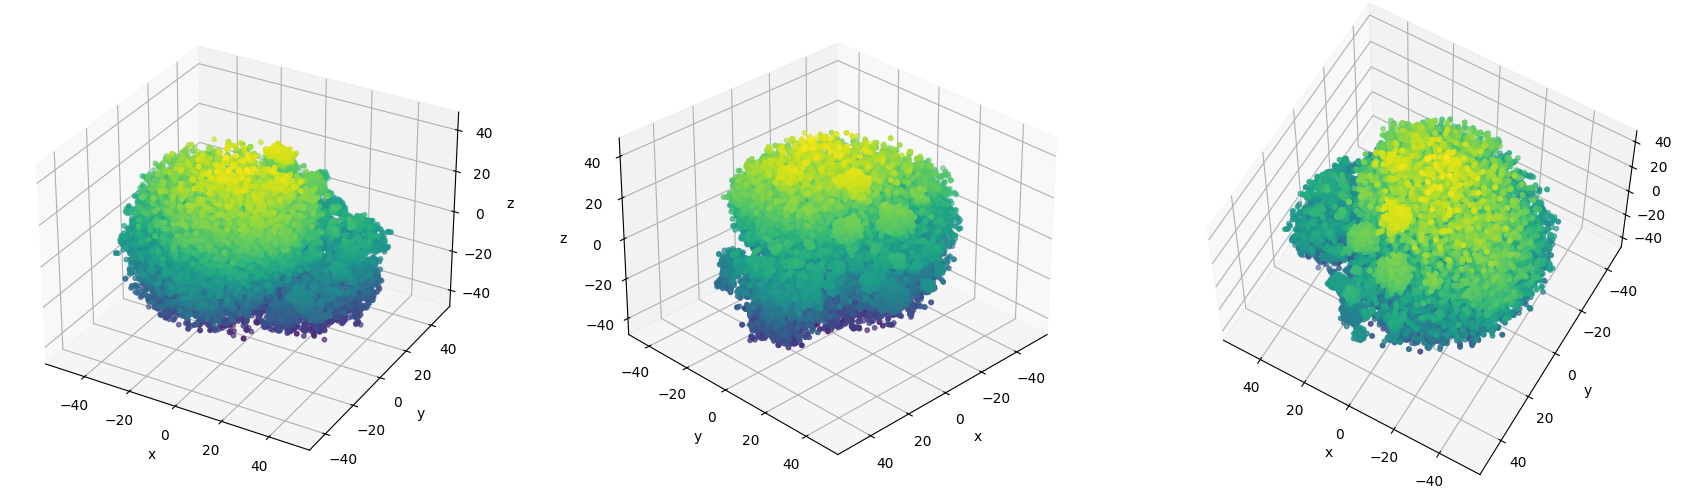

In [13]:
if os.path.exists(saved_embeddings_3d_path):
	embeddings_3d = np.load(saved_embeddings_3d_path)
else:
	tsne = TSNE(n_components=3, random_state=42)
	embeddings_3d = tsne.fit_transform(lyrics_embeddings)

fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=embeddings_3d[:, 2], s=10)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=embeddings_3d[:, 2], s=10)
ax2.view_init(elev=30, azim=45)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=embeddings_3d[:, 2], s=10)
ax3.view_init(elev=60, azim=120)  
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.tight_layout()
plt.show()


In [14]:
np.save('misc/lyrics_embeddings_3d.npy', embeddings_3d)

In [20]:

random_index = np.random.randint(0, len(embeddings_3d))

nn_model = NearestNeighbors(n_neighbors=6)
nn_model.fit(embeddings_3d)

distances, indices = nn_model.kneighbors(embeddings_3d[random_index].reshape(1, -1))

nearest_indices = indices[0][1:]
nearest_indices = np.insert(nearest_indices, 0, random_index)

print("target song:", random_index)
track_data.iloc[nearest_indices][['name', 'artist', 'year', 'loudness', 'danceability', 'liveness', 'tags']]

target song: 18534


,name,artist,year,loudness,danceability,liveness,tags
track_id,,,,,,,
TRITFEA12903CF0E99,Dacia Hiperboreană,Negură Bunget,2010,-4.799,0.297,0.0341,"black_metal, dark_ambient"
TRJIOIM12903CF5159,Simple Boy,Karnivool,2009,-5.043,0.429,0.3600,progressive_rock
TRNZCVL128EF3437B1,Don Gon Do It,The Rapture,2006,-6.263,0.684,0.7950,"electronic, indie, indie_rock, dance, post_pun..."
TROZSRW128F4259F9C,Don't Look Too Far,Anathema,1999,-9.747,0.470,0.1770,"progressive_rock, progressive_metal, doom_metal"
TRBCBIO12903CC9109,Code,Faithless,2001,-26.187,0.190,0.2120,"electronic, trip_hop"
TRNDYQB128F930ED91,The Beloved,Anathema,1996,-8.268,0.209,0.0656,"progressive_rock, progressive_metal, doom_meta..."
